# EDA Project 2
_______

### Background
These data provide a window into how people are interacting with the government online. The data come from a unified Google Analytics account for U.S. federal government agencies known as the Digital Analytics Program. This program helps government agencies understand how people find, access, and use government services online. The program does not track individuals, and anonymizes the IP addresses of visitors.

Not every government website is represented in these data. Currently, the Digital Analytics Program collects web traffic from around 400 executive branch government domains, across about 5,700 total websites, including every cabinet department.

One of the challenges of this project was acquiring data.  The original dataset we prospected was found to be corrupted.
After looking at the data, we found that the data contained so many errors, it would have been nearly impossible to complete the project as planned.

The data was corrupted by human error.  The developers who maintain the dataset, allowed synthetic data to contaminate the downloadable `.csv` files they make available to the public.  Over half of the observations contained website domains such as www.fakesite.com.  

 


### Data Collection

Instead of waiting for the data errors to be fixed and run the risk of having incomplete data for our project, we decided to proceed with acquiring data through the API.  We did need to adjust our initial data questions as the API is still in BETA and did not have the same headers available as the `.csv` files.  Where we did lose some variable information, we did gain the ability to acquire time-series data, which was not available in the original dataset. 

#### Reports

The analytics.usa.gov has made the following datasets available for download:
- Download: Refers to the number of times a file or asset has been downloaded from a website.
- Traffic-source: Refers to the channel or medium that a visitor used to reach a website, such as organic search, social media, or paid advertising.
- Device-model: Refers to the specific model of device that a visitor used to access a website, such as an iPhone X or Samsung Galaxy S21.
- Domain: Refers to the main domain name of a website, such as example.com.
- Site: Refers to a specific subdomain or section of a website, such as blog.example.com.
- Second-level-domain: Refers to the part of a domain name that comes before the top-level domain (TLD), such as example in example.com.
- Language: Refers to the primary language of a website or the language preference of a visitor's browser.
- OS-browser: Refers to the combination of operating system and web browser used by a visitor to access a website, such as Windows 10 and Chrome.
- Windows-browser: Refers specifically to web browsers running on the Windows operating system, such as Internet Explorer or Microsoft Edge.
- Browser: Refers to the specific web browser used by a visitor to access a website, such as Chrome, Firefox, or Safari.
- Windows-ie: Refers specifically to the Internet Explorer web browser running on the Windows operating system.
- OS: Refers to the specific operating system used by a visitor to access a website, such as Windows, macOS, iOS, or Android.
- Windows: Refers specifically to the Windows operating system.
- IE: Refers specifically to the Internet Explorer web browser.

### Inclusion and Exclusion Assumptions for Report Selection

#### Included Reports 
How does this support our questions?

**Language_report_all_agencies.parquet** - Daily visits per language to each agency sites

**Site_report_all_agencies.parquet** - Is not clear what is the difference between this and the domain report.

**Traffic-source_report_all_agencies.parquet** - Daily visits to agencies sites broken down by source domain.


#### Agencies and Time Selection Criteria

The agencies of interest are:
‘health-human-services', 'postal-service', 'social-security-administration','treasury'

The time period of interest is the period surrounding the COVID-19 pandemic, ~March 2020-February 2023.

## Workflow Goals

### Import Libraries

In [1]:
from collections.abc import Sequence
from IPython.display import display
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from utils import api_to_parquet, remove_outliers

pd.options.display.max_colwidth = 100
pd.options.display.max_rows = 200
%matplotlib inline

### API Call

This is the script we used to make the API queries.  The function `api_to_parquet()` can be found in `./utils.py`.

In [2]:
# list_of_agencies = [
#     'health-human-services', 
#     'postal-service', 
#     'social-security-administration',
#     'treasury',
#     ]
# list_of_reports = ['site', 'traffic-source', 'language']

# # api key 
# api_key = 'your_api_key_here'

# # call the function
# api_to_parquet(list_of_agencies, list_of_reports, api_key, response_limit=1000)


### Load Dataset

In [3]:
df_sites = pd.read_parquet('./data/site_report_all_agencies.parquet')
df_traffic_source = pd.read_parquet('./data/traffic-source_report_all_agencies.parquet')
df_language = pd.read_parquet('./data/language_report_all_agencies.parquet')

In [4]:
display(df_sites.info())
display(df_traffic_source.info())
display(df_language.info())

<class 'pandas.core.frame.DataFrame'>
Index: 667504 entries, 0 to 104
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   id             667504 non-null  int64         
 1   date           667504 non-null  datetime64[ns]
 2   report_name    667504 non-null  object        
 3   report_agency  667504 non-null  object        
 4   domain         667504 non-null  object        
 5   visits         667504 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 35.6+ MB


None

<class 'pandas.core.frame.DataFrame'>
Index: 161296 entries, 0 to 999
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   id                   161296 non-null  int64         
 1   date                 161296 non-null  datetime64[ns]
 2   report_name          161296 non-null  object        
 3   report_agency        161296 non-null  object        
 4   source               161296 non-null  object        
 5   visits               161296 non-null  int64         
 6   has_social_referral  161296 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(4)
memory usage: 9.8+ MB


None

<class 'pandas.core.frame.DataFrame'>
Index: 978426 entries, 0 to 188
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   id             978426 non-null  int64         
 1   date           978426 non-null  datetime64[ns]
 2   report_name    978426 non-null  object        
 3   report_agency  978426 non-null  object        
 4   visits         978426 non-null  int64         
 5   language       978426 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 52.3+ MB


None

### Data Cleansing

##### Checking for `NaN` and missing values.

Here we are doing a side by side comparison of the 3 reports to check the sum of the number of `NaN` values.  There no `NaN` values in any of the reports.  

In [5]:
ct_report = pd.concat([df_sites.isna().sum(), df_language.isna().sum(), df_traffic_source.isna().sum()], axis=1, keys = ['Sites Report', 'Language Report', 'Traffic Source Report'])
ct_report.fillna("Column not in report", inplace=True)
display(ct_report)

,Sites Report,Language Report,Traffic Source Report
id,0.0,0.0,0.0
date,0.0,0.0,0.0
report_name,0.0,0.0,0.0
report_agency,0.0,0.0,0.0
domain,0.0,Column not in report,Column not in report
visits,0.0,0.0,0.0
language,Column not in report,0.0,Column not in report
source,Column not in report,Column not in report,0.0
has_social_referral,Column not in report,Column not in report,0.0


##### Checking Duplicate Values
We can see that our data is being duplicated, this could be due to the data curation errors. We will need to remove these duplicated values.  

In [6]:
df_sites[(df_sites['id'].duplicated(keep=False)) & (df_sites['report_agency']=="treasury")].sort_values('id').head(20)

,id,date,report_name,report_agency,domain,visits
2287,58005371,2020-01-31,site,treasury,irs.gov,3904424
3465,58005371,2020-01-31,site,treasury,irs.gov,3904424
2288,58005372,2020-01-31,site,treasury,sa.www4.irs.gov,2409251
3466,58005372,2020-01-31,site,treasury,sa.www4.irs.gov,2409251
2289,58005373,2020-01-31,site,treasury,apps.irs.gov,256488
3467,58005373,2020-01-31,site,treasury,apps.irs.gov,256488
2290,58005374,2020-01-31,site,treasury,treasury.gov,63939
3468,58005374,2020-01-31,site,treasury,treasury.gov,63939
2291,58005375,2020-01-31,site,treasury,home.treasury.gov,52530
3469,58005375,2020-01-31,site,treasury,home.treasury.gov,52530


In [7]:
df_sites.drop_duplicates(subset='id', keep='first', inplace=True)
df_traffic_source.drop_duplicates(subset='id', keep='first', inplace=True)
df_language.drop_duplicates(subset='id', keep='first', inplace=True)

##### Trim Date Range
We would like to ensure that all three of our reports are consistent in the start and end dates 

In [8]:
# Find the maxi-min (start date) and mini-max (end date) dates across all three dataframes.
min_date = max(df_sites['date'].min(), df_traffic_source['date'].min(), df_language['date'].min())
max_date = min(df_sites['date'].max(), df_traffic_source['date'].max(), df_language['date'].max())

# Filter the 3 dataframes to only include the dates that are in all three dataframes.
df_sites_filtered = df_sites[(df_sites['date'] >= min_date) & (df_sites['date'] <= max_date)]
df_traffic_source_filtered = df_traffic_source[(df_traffic_source['date'] >= min_date) & (df_traffic_source['date'] <= max_date)]
df_language_filtered = df_language[(df_language['date'] >= min_date) & (df_language['date'] <= max_date)]

We can clearly see that prior to filtering, there was almost a 3 month difference in the data collection start time between the traffic source report and the site and language reports.  There is also a 1 day difference in the end date between the traffic source report and the site and language reports.  After filtering, we can see that all three reports now have a consistent start and end date and we can overwrite the original dataframes with the filtered outputs.   

In [9]:
# Create a summary dataframe to show the min and max dates before and after filtering.
summary = pd.DataFrame({
    'DataFrame': ['df_sites', 'df_traffic_source', 'df_language'],
    'Min Date Before': [df_sites['date'].min(), df_traffic_source['date'].min(), df_language['date'].min()],
    'Max Date Before': [df_sites['date'].max(), df_traffic_source['date'].max(), df_language['date'].max()],
    'Min Date After': [df_sites_filtered['date'].min(), df_traffic_source_filtered['date'].min(), df_language_filtered['date'].min()],
    'Max Date After': [df_sites_filtered['date'].max(), df_traffic_source_filtered['date'].max(), df_language_filtered['date'].max()],
})

# Display the summary dataframe.
display(summary)

,DataFrame,Min Date Before,Max Date Before,Min Date After,Max Date After
0,df_sites,2020-01-01,2023-04-17,2020-03-26,2023-04-17
1,df_traffic_source,2020-03-26,2023-04-18,2020-03-26,2023-04-17
2,df_language,2020-01-01,2023-04-17,2020-03-26,2023-04-17


In [10]:
df_sites = df_sites_filtered
df_traffic_source = df_traffic_source_filtered
df_language = df_language_filtered

##### Check for string formatting
We suspect that there may exist some unexpected string formatting within some of the reports.  Because we are expecting to answer analytics questions on the traffic source and user language, we want to inspect the columns for any odd string formatting patterns.  Starting with the traffic source, we can see that there are large sources of traffic that are outside the typical alphanumeric web domain format and use atypical separators (typical being periods, commas, dashes, and underscores).  The "(direct)" source has a very large value so we will inspect further.

In [11]:
# create a new regex pattern.
pattern = r'^[\w\.\-\_]+$'

# create a new column that contains the boolean value of whether the source column matches the pattern.
source_pattern = df_traffic_source['source'].str.contains(pattern)
nonalpha_source = df_traffic_source.loc[~source_pattern, 'source']
nonalpha_visits = df_traffic_source.loc[~source_pattern, 'visits']

# create a new dataframe that contains the non-alpha traffic sources and their visits.
df_nonalpha_traffic = pd.DataFrame({'source': nonalpha_source, 'visits': nonalpha_visits})

# display the dataframe.
df_nonalpha_traffic.groupby('source').sum().sort_values('visits', ascending=False).head(20)

,visits
source,
(direct),446835783
PaidVideo;5782978,118976
atlnet2.bi.ssa.gov:8080,108985
PaidVideo;4190268,98310
Order Shipped Flow - Fulfilled Order,78874
REA TRAN-Shipping Confirmation,70833
Delivery Notification - In Transit / Shipped (Nov update),59470
CDC High Risk,58056
CM Eblast,48646


After a deeper inspection of "(direct traffic)", we can see there is a second "direct" source that we may want to consider combining.  However, we currently don't have specific information on the meaning of these values.  Because there is a large number of "(direct)" sources and "direct" is much smaller in relation, we can forgo combining the two values unless we find it necessary later in our analysis.  

In [12]:
source_direct = df_traffic_source['source'].str.contains(r'.*direct.*', case=False)
df_direct_traffic = df_traffic_source.loc[source_direct]
df_direct_traffic[['source', 'visits']].groupby('source').sum().sort_values('visits', ascending=False).head(20)

,visits
source,
(direct),446835783
directpay.irs.gov,128755
treasurydirect.gov,74047
eyebuydirect.com,50544
godirect.gov,34015
directvapor.com,17597
direct,13511
lensdirect.com,11164
applytoday$utm_medium=directmail%utm_campaign=nationalrecruitment,9546


Next, we inspect string patterns in the language column within the language report.  The language codes are defined in <add name of language spec> which, at a high level, is formatted by language-locale.  We can see there are many languages that are not in the correct format based on the specification.  The "en-us@posix" value contains a substantial number of visits.  We will need to consider wether to combine these in generally by language or specifically by language-locale.

In [13]:
lang_pattern = df_language['language'].str.contains(pattern)
nonalpha_lang = df_language.loc[~lang_pattern, 'language']
nonalpha_visits = df_language.loc[~lang_pattern, 'visits']

df_nonalpha_lang = pd.DataFrame({'language': nonalpha_lang, 'visits': nonalpha_visits})

df_nonalpha_lang.groupby('language').sum().sort_values('visits', ascending=False).head(20)


,visits
language,
(not set),8132958
en-us@posix,259877
q=0.8,23663
en-us;q=0.8,21091
en-us;q=0.9,12212
q=0.9,12023
en@us,949


#### Drop Unnecessary Columns
Finally we will want to see if we can drop any columns that aren't necessary for analysis.  The only column we suspect we will need to consider dropping is the "id" column if the ids are not shared across all the reports. We are making the assumption that the ids are generated 

In [14]:
# Drop columns using .drop()
df_sites = df_sites.drop(columns=['id'])
df_traffic_source = df_traffic_source.drop(columns=['id'])
df_language = df_language.drop(columns=['id'])

#### Cleansing Summary

In total we lost 209,015 samples in the site report, 8,678 in the traffic source report, and 491,373 samples from the language report.

In time, we lost ~3 months from the site and language reports.

In [15]:
display(df_sites.info())
display(df_traffic_source.info())
display(df_language.info())

<class 'pandas.core.frame.DataFrame'>
Index: 458489 entries, 0 to 69
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   date           458489 non-null  datetime64[ns]
 1   report_name    458489 non-null  object        
 2   report_agency  458489 non-null  object        
 3   domain         458489 non-null  object        
 4   visits         458489 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 21.0+ MB


None

<class 'pandas.core.frame.DataFrame'>
Index: 152618 entries, 0 to 999
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   date                 152618 non-null  datetime64[ns]
 1   report_name          152618 non-null  object        
 2   report_agency        152618 non-null  object        
 3   source               152618 non-null  object        
 4   visits               152618 non-null  int64         
 5   has_social_referral  152618 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 8.2+ MB


None

<class 'pandas.core.frame.DataFrame'>
Index: 487053 entries, 0 to 127
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   date           487053 non-null  datetime64[ns]
 1   report_name    487053 non-null  object        
 2   report_agency  487053 non-null  object        
 3   visits         487053 non-null  int64         
 4   language       487053 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 22.3+ MB


None

### Data Exploration

1. How many sites and agencies do the reports contain information about?
    - Count unique combinations of agencies and sites
2. Any missing or null values? Any other gaps in the data?
    - For each report and column, are there any NaN values
3. Do aggregate visit values fall within expectations (eg. # visits as % of US population seems realistic)
   - Sanity of volume of visits. From the site report, for a given day calculate the number of visits per agency. Compare against each other and see the scale of the value
4. Are there any unexpected values? (negative domain visits, anomaly: large day over day drops in visits)
    - We could choose a large domain and for a given month, show a table with d/d differences %s.
    - This might be a good moment to explain the weekly seasonality of visits observe in the data (weekends have lower # visits)
5. Do we understand the meaning of all columns? For example “source”
   - Source: page where user is coming from (direct), search referral (google.com, , social referral facebook, ig, twitter)
6. Outliers: are there any domains with too high or too low # visits? 


##### Question 1. 

How many sites and agencies does the site report contain information about?

In [16]:
df_sites.groupby(['report_agency'])['domain'].nunique().sort_values(ascending=False)

report_agency
health-human-services             1044
treasury                           119
postal-service                      56
social-security-administration       9
Name: domain, dtype: int64

In [17]:
df_sites[df_sites['report_agency'] == 'social-security-administration']['domain'].unique()

array(['ssa.gov', 'faq.ssa.gov', 'search.ssa.gov', 'secure.ssa.gov',
       'choosework.ssa.gov', 'oig.ssa.gov', 'beta.ssa.gov',
       'yourtickettowork.ssa.gov', 'oig-demo.ssa.gov'], dtype=object)

##### Question 1 answer:
- The site reports contains information about 4 agencies (Health & Human Services, Treasury, Postal Service and Social Secutiry Administration)
- Health & Human Services is the agency with the largest number of domains (1044), whereas Social Security Administration is the lower (9)
- Below is a spot-check of the 9 domains under Social Security Administration

##### Question 2. 
Any missing or null values? Any other gaps in the data?
- For each report and column, are there any NaN values

In [18]:
print("ITES INFO")
print(df_sites.isna().sum())
print("df_sites time period:", df_sites['date'].min(), "-", df_sites['date'].max())
print()
print("TRAFFIC_SOURCE INFO")
print(df_traffic_source.isna().sum())
print("df_traffic_source time period:", df_traffic_source['date'].min(), "-", df_traffic_source['date'].max())
print()
print("LANGUAGES INFO")
print(df_language.isna().sum())
print("df_languages time period:", df_language['date'].min(), "-", df_language['date'].max())
print()

ITES INFO
date             0
report_name      0
report_agency    0
domain           0
visits           0
dtype: int64
df_sites time period: 2020-03-26 00:00:00 - 2023-04-17 00:00:00

TRAFFIC_SOURCE INFO
date                   0
report_name            0
report_agency          0
source                 0
visits                 0
has_social_referral    0
dtype: int64
df_traffic_source time period: 2020-03-26 00:00:00 - 2023-04-17 00:00:00

LANGUAGES INFO
date             0
report_name      0
report_agency    0
visits           0
language         0
dtype: int64
df_languages time period: 2020-03-26 00:00:00 - 2023-04-17 00:00:00



**Question 2 Answer:** There are no missing or null values in our dataset. There is a gap in our data however, where the date range of traffic_source is slightly less than the other two dataset. To compensate for this we can simply cut the date range of all the datasets so that they will match.

In [19]:
# cleaning: making all date ranges the same
start_date = max(df_sites['date'].min(), df_traffic_source['date'].min(), df_language['date'].min())
end_date = min(df_sites['date'].max(), df_traffic_source['date'].max(), df_language['date'].max())

df_sites = df_sites[df_sites['date'].between(start_date, end_date)]
df_traffic_source = df_traffic_source[df_traffic_source['date'].between(start_date, end_date)]
df_language = df_language[df_language['date'].between(start_date, end_date)]

##### Question 3. 
Do aggregate visit values fall within expectations (eg. # visits as % of US population seems realistic)
- Sanity of volume of visits. From the site report, for a given day calculate the number of visits per agency. Compare against each other and see the scale of the value

In [20]:
total_visits = df_sites['visits'].sum()
total_days = (df_sites['date'].max() - df_sites['date'].min()).days + 1
avg_visits_per_day = total_visits / total_days

# gotten from https://www.census.gov/popclock/ on 4-20-2023
us_population = 334651030

visits_percentage_of_us_population = avg_visits_per_day / us_population * 100

print("Average visits per day:", avg_visits_per_day)
print("Average daily visits as percentage of US population:", visits_percentage_of_us_population)

Average visits per day: 38361909.98300537
Average daily visits as percentage of US population: 11.463257705498581


In [21]:
def visits_on_day(check_date):
    visits_per_agency = df_sites[df_sites['date'] == check_date].groupby(['report_agency'])['visits'].sum()

    print("Visits per agency on " + str(check_date))
    print(visits_per_agency)
    print()
    print("Visits per agency as percentage of US population on " + str(check_date))
    print(visits_per_agency / us_population * 100)
    
check_date = df_traffic_source['date'].min()
visits_on_day(check_date)

Visits per agency on 2020-03-26 00:00:00
report_agency
health-human-services             28450354
postal-service                    12207292
social-security-administration     1018944
treasury                           6026646
Name: visits, dtype: int64

Visits per agency as percentage of US population on 2020-03-26 00:00:00
report_agency
health-human-services             8.501499
postal-service                    3.647768
social-security-administration    0.304480
treasury                          1.800875
Name: visits, dtype: float64


**Question 3 Answer:** Our results fall within realistic expectations.

##### Question 4. 
Are there any unexpected values? (negative domain visits, anomaly: large day over day drops in visits)
- Take a closer look at a large domain and for a given month, show a table with Day-over-Day differences by percent change.
-  Explain the weekly seasonality of visits observe in the data (weekends have lower # visits)

In [22]:
# Index of the top 5 domains by visits.
top_domains = df_sites.groupby('domain')['visits'].sum().nlargest(5).index

# Convert the date column to a daily periodicity.
df_sites['day'] = df_sites['date'].dt.to_period('D')

# Get daily data for the top domains grouped by domain and date.
daily_data = df_sites[df_sites['domain'].isin(top_domains)].groupby(['domain', 'day'])['visits'].sum().reset_index()

# Calculate the day-over-day percentage change in visits for each domain.
daily_data['pct_change'] = daily_data.groupby('domain')['visits'].pct_change()

# Filter the data to keep only the largest > 50% drops.
large_drops = daily_data[daily_data['pct_change'] < -0.5]


In [23]:
# Sort the data by the largest percentage in drops.
large_drops.sort_values('pct_change', ascending=True)

,domain,day,visits,pct_change
4430,tools.usps.com,2020-08-09,2633276,-0.684534
1628,irs.gov,2021-10-16,1157203,-0.562875
1813,irs.gov,2022-04-19,4909450,-0.557722
1304,irs.gov,2020-11-26,510725,-0.555881
1171,irs.gov,2020-07-16,3141567,-0.540399
4933,tools.usps.com,2021-12-25,3303117,-0.530009
2032,irs.gov,2022-11-24,473203,-0.522440
4870,tools.usps.com,2021-10-23,1794033,-0.511199
4568,tools.usps.com,2020-12-25,10318168,-0.506236


/tmp/ipykernel_3702/3206962186.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_major_formatter(plt.FixedFormatter(large_drops['day'].astype(str).unique()))


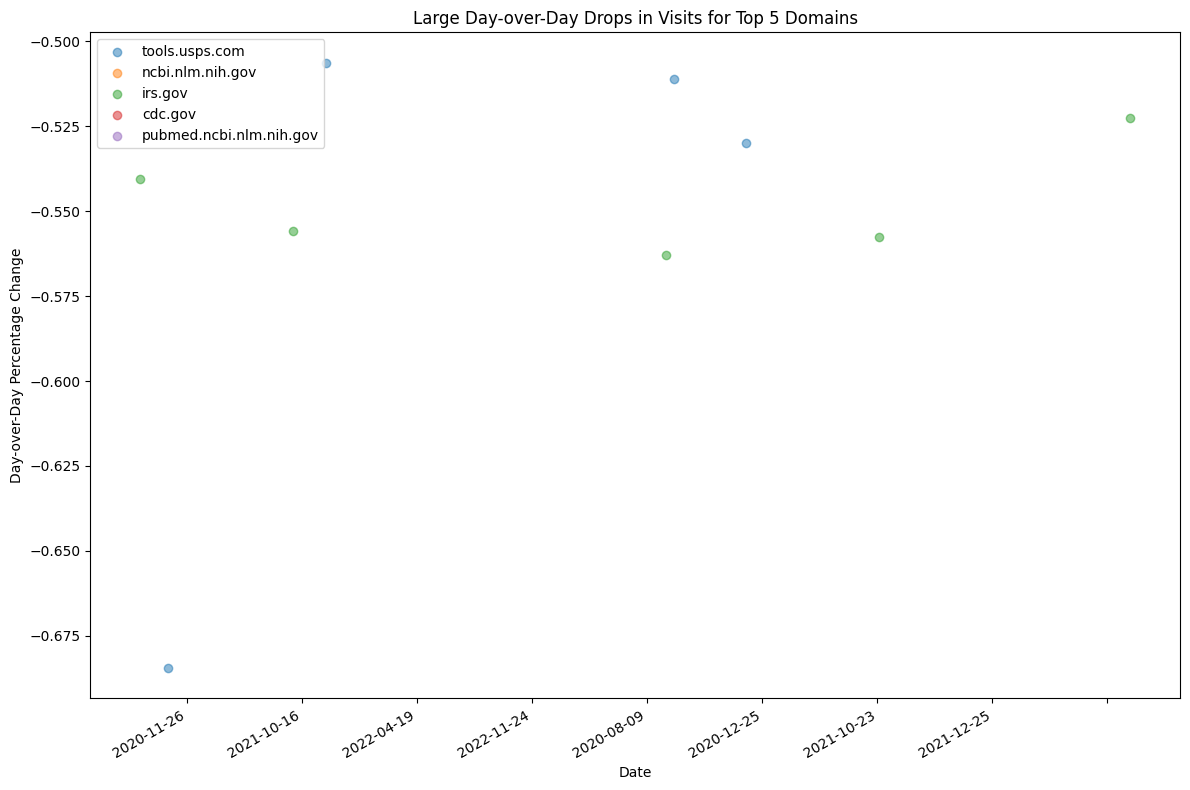

In [24]:
# Create a scatter plot to visualize large
fig, ax = plt.subplots(figsize=(12, 8))
for domain in top_domains:
    domain_data = large_drops[large_drops['domain'] == domain]
    ax.scatter(x=domain_data['day'].dt.to_timestamp(), y=domain_data['pct_change'], alpha=0.5, label=domain)

# Format the x-axis to display dates
ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
ax.xaxis.set_major_formatter(plt.FixedFormatter(large_drops['day'].astype(str).unique()))

# Set axis labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Day-over-Day Percentage Change')
ax.set_title('Large Day-over-Day Drops in Visits for Top 5 Domains')

# Rotate x-axis labels
plt.setp(ax.get_xticklabels(), rotation=30, ha='right')

# Add a legend with tight layout and show the plot
plt.legend()
plt.tight_layout()
plt.show()

Exploring seasonality changes

In [25]:
# Set the start and end dates for the data to zoom
start_date = '2020-03-26'
end_date = '2023-02-01'

# Group by agency and domain
top_domains_by_agency = df_sites.groupby(['report_agency', 'domain'])['visits'].sum().reset_index()

# Get the top 5 domains for each agency
top_domains_by_agency = top_domains_by_agency.groupby('report_agency').apply(lambda x: x.nlargest(5, 'visits')).reset_index(drop=True)

# Set the date column to a monthly periodicity.
df_sites['month'] = df_sites['date'].dt.to_period('M')

# Monthly visits for each domain with start and end dates grouped by agency, domain and month.
monthly_data = df_sites[(df_sites['domain'].isin(top_domains_by_agency['domain'])) & (df_sites['date'] >= start_date) & (df_sites['date'] <= end_date)].groupby(['report_agency', 'domain', 'month'])['visits'].sum().reset_index()

# Show the top 5 domains for each agency
report_agencies = df_sites['report_agency'].unique()


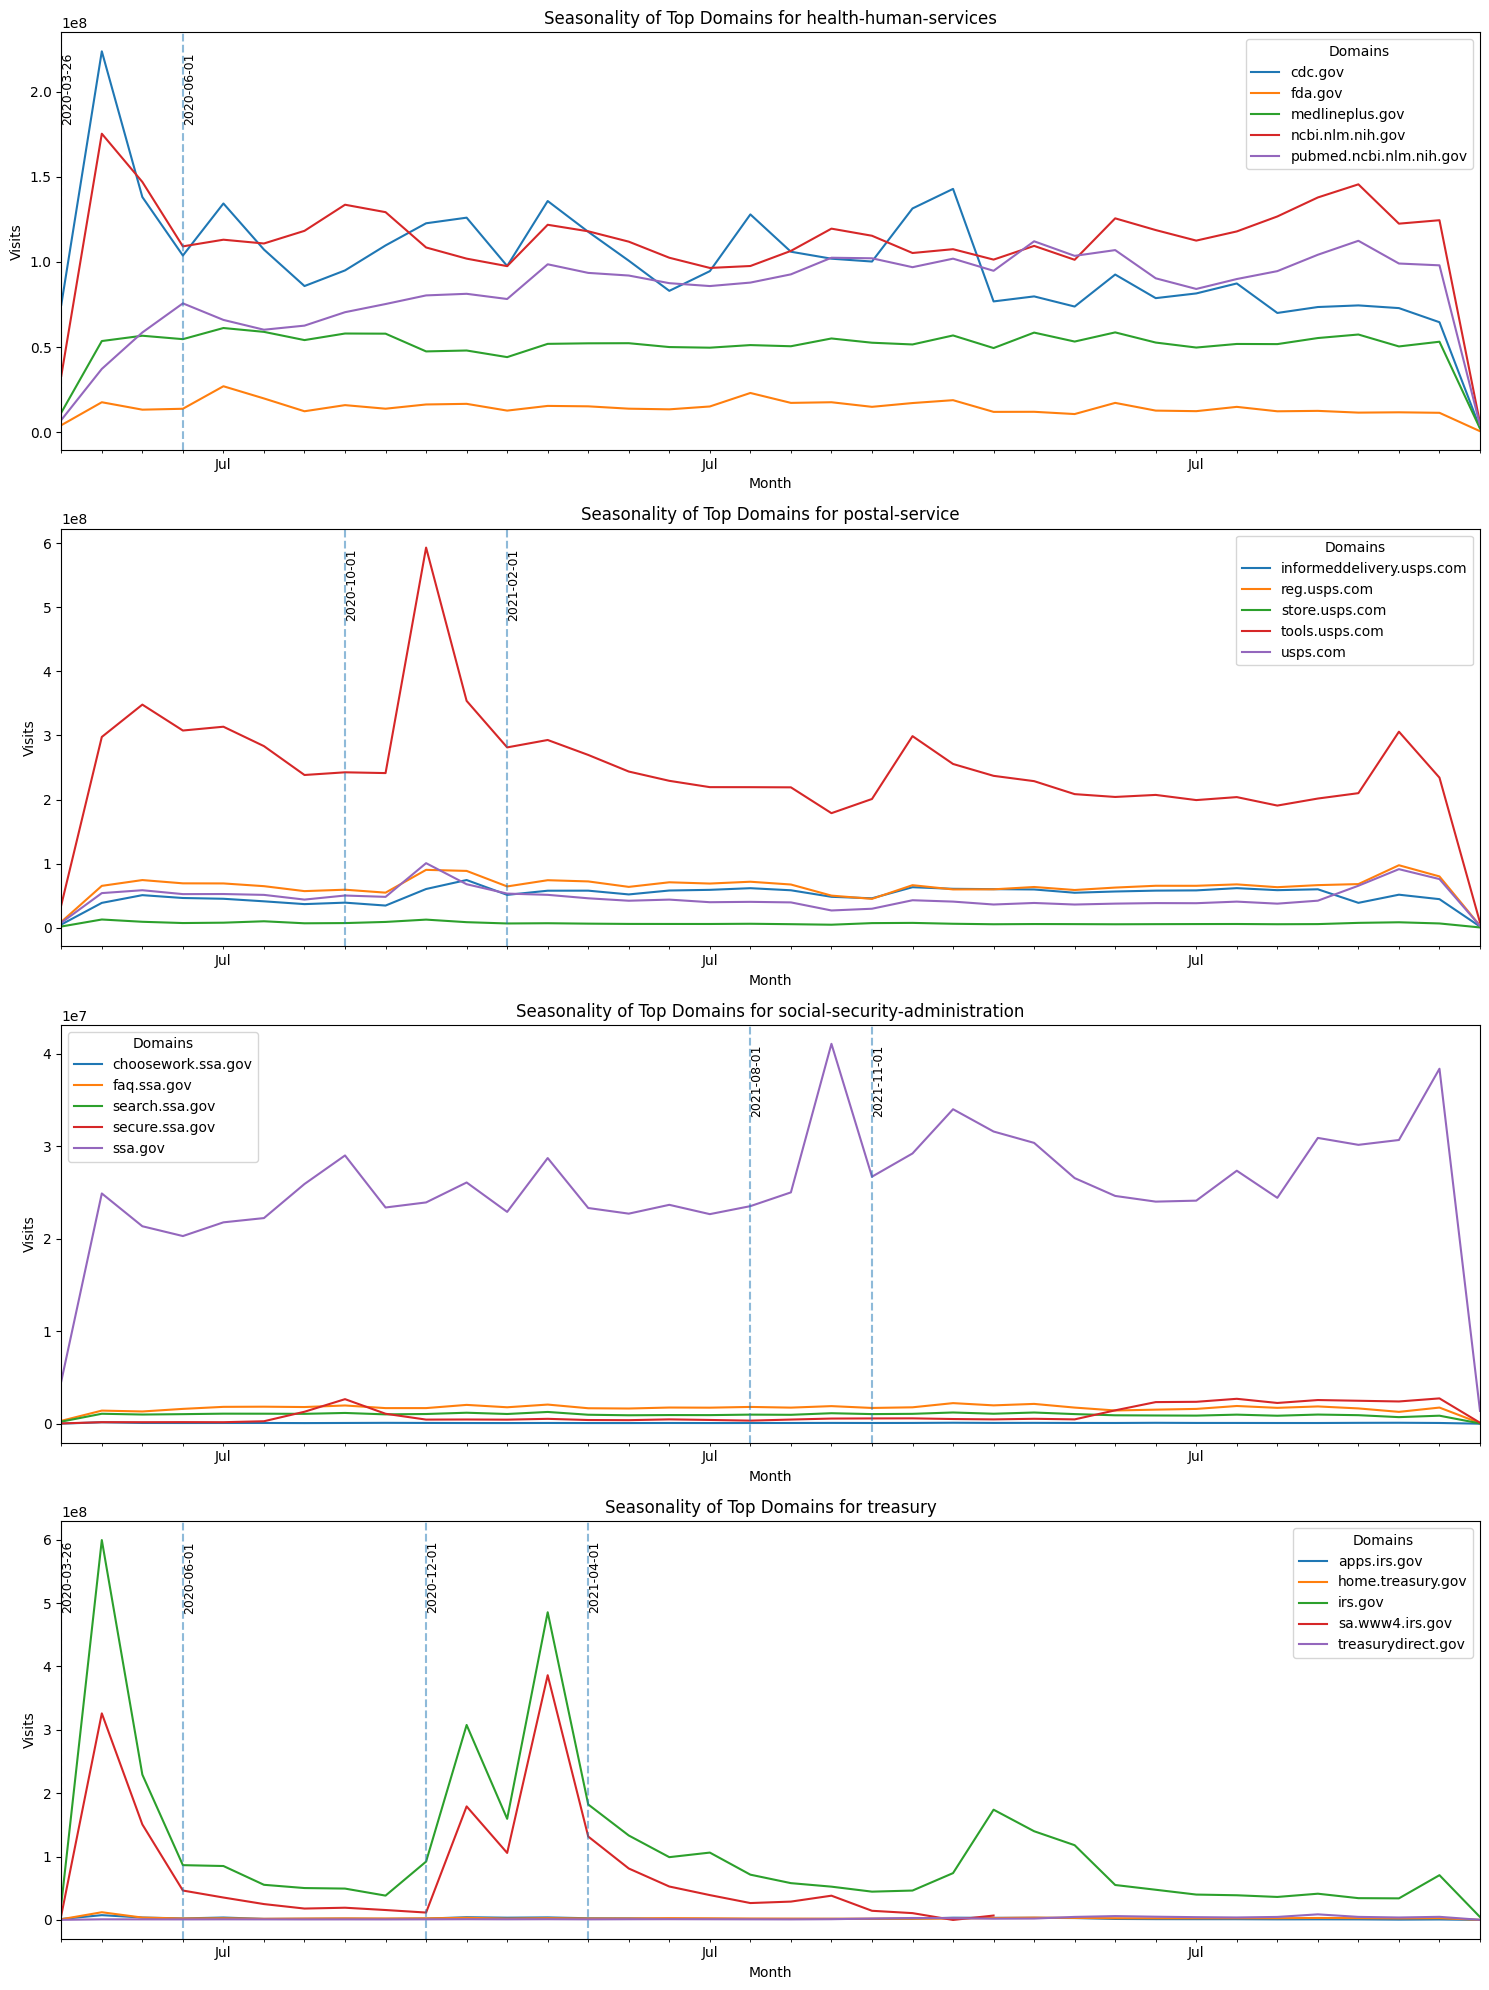

In [46]:
# Create a figure with a subplot for each agency
fig, axes = plt.subplots(nrows=len(report_agencies), figsize=(15, 5 * len(report_agencies)))

# Define a list of tuples with the agency name and its corresponding list of dates for axvlines
vertical_lines = [
    ('health-human-services', ['2020-03-26', '2020-06-01']),
    ('postal-service', ['2020-10-01', '2021-02-01']),
    ('social-security-administration', ['2021-08-01', '2021-11-01']),
    ('treasury', ['2020-12-01', '2021-04-01','2020-03-26', '2020-06-01']),
]

# Create a dictionary for easier lookup
vertical_lines_dict = dict(vertical_lines)

# Loop through each agency and plot the monthly visits for each domain
for i, agency in enumerate(report_agencies):
    agency_data = monthly_data[monthly_data['report_agency'] == agency].pivot_table(values='visits', index='month', columns='domain', aggfunc='sum')
    agency_data.plot(ax=axes[i], title=f"Seasonality of Top Domains for {agency}", xlabel="Month", ylabel="Visits")
    axes[i].legend(title='Domains')

    # Add axvlines for each agency with different dates
    for date in vertical_lines_dict[agency]:
        x = pd.to_datetime(date)
        axes[i].axvline(x, linestyle='--', alpha=0.5)
        axes[i].text(x, axes[i].get_ylim()[1] * 0.95, date, rotation=90, va='top', ha='left', fontsize=9)

    axes[i].xaxis.set_major_locator(mdates.YearLocator())
    axes[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Add a tight layout and show the plot
plt.tight_layout()
plt.show()

##### Question 4 Answer:

**Drops in Visits**
The largest drops in percent change to traffic were for the domains irs.gov and tools.ups.com.  The drops are likely due to the end of tax season and the end of the US Presendential Election.  

**Seasonality**

***health-human-services*** - Between March 2020 and June 2020, there was a noticeable spike in site visits to cdc.gov and ncbi.nlm.nih.gov. This increase in traffic can be largely attributed to the COVID-19 pandemic, which had a significant impact on public health and the global economy during this time.

The Centers for Disease Control and Prevention (CDC) website, cdc.gov, is a primary source of information on public health and safety, including guidelines and recommendations to prevent the spread of infectious diseases. The public's increased reliance on the CDC website for critical information likely contributed to the spike in site visits during this period.  

Similarly, ncbi.nlm.nih.gov, the website for the National Center for Biotechnology Information (NCBI), also experienced a surge in traffic. The NCBI is a leading source of scientific and medical information, housing a vast collection of databases and resources related to biotechnology and biomedical research.  This increased demand for research on the coronavirus likely contributed to the heightened site visits during the March-June 2020 timeframe.

***postal-service*** - Between October 2020 and February 2021, there was a noticeable spike in site visits to tools.usps.com, the United States Postal Service (USPS) website. This increase in traffic can be primarily attributed to the 2020 United States Presidential Election.  The 2020 Presidential Election took place on November 3, 2020. In the lead-up to the election, there was a heightened emphasis on mail-in voting due to concerns about the spread of COVID-19 at in-person polling places. 

***social-security-administration*** - We are not able to conclude why there was a noticable spike in site visits to ssa.gov.  Some reasons may include service changes offered by ssa.gov during the pandemic.

***treasury*** - Between March 2020 and June 2020, and then again between December 2020 and April 2021, there were notable spikes in site visits to irs.gov and sa.www4.irs.gov, the official websites of the United States Internal Revenue Service (IRS). These increases in traffic can be mainly attributed to two key factors: the impact of the COVID-19 pandemic on federal tax filing and the distribution of stimulus payments.  The COVID-19 pandemic motivated more people to filing their taxes online instead of in person.  

The federal government approved multiple rounds of economic stimulus payments to provide financial relief to millions of Americans during the COVID-19 pandemic. The IRS was responsible for distributing these payments. The sa.www4.irs.gov website, became a primary resource for individuals tracking their stimulus payments.

We were only able to observe some pattern of seasonality for the 4 tax seasons included in our date range for irs.gov which correlates with the annual tax season. 

##### Question 5.
Do we understand the meaning of all columns? For example, “source”?
- Source: page where user is coming from (direct, search referral (google.com, , social referral facebook, ig, twitter)

In [27]:
df_sites.columns

Index(['date', 'report_name', 'report_agency', 'domain', 'visits', 'day',
       'month'],
      dtype='object')

In [28]:
df_language.columns

Index(['date', 'report_name', 'report_agency', 'visits', 'language'], dtype='object')

In [29]:
df_traffic_source.columns

Index(['date', 'report_name', 'report_agency', 'source', 'visits',
       'has_social_referral'],
      dtype='object')

##### Question 5 Answer: 
While there is some good information about the data at https://analytics.usa.gov/data/ and https://digital.gov/guides/dap/, there doesn't seem to be detailed documentation for each of the reports we pulled. This might be in part due to the fact that the API we used is in beta mode. However, the column names are mostly self-explanatory and through spot checking the data and with some experience having worked with Web traffic datasets in the past, we were able to come to the following conclusions:
   - `id`: random unique identifier for each row in each report. It can't be used to join across reports so it could potentially be dropped.
   - `date`: datetime field
   - `report_name`: name of each of the 3 reports pulled
   - `report_agency`: name of each of the 4 agencies for which we have data
   - `domain`: web domain. Each domain (eg. ssa.gov) aggregates data for all its sites (eg. ssa.gov/retirement)
   - `visits`: number of visits to each individual domain. Tipically the page_view metric counts the number of times a page is viewed, whereas visits counts the number of sessions for visitors
   - `language`: we think this represents the inferred language of the user visiting the page
   - `source`: the page where the visit originated from. For example, if someone reaches ssa.gov by clicking a link at google.com, then google.com would be the source for that visit

##### Question 6.
Outliers: are there any domains with too high or too low # visits? 

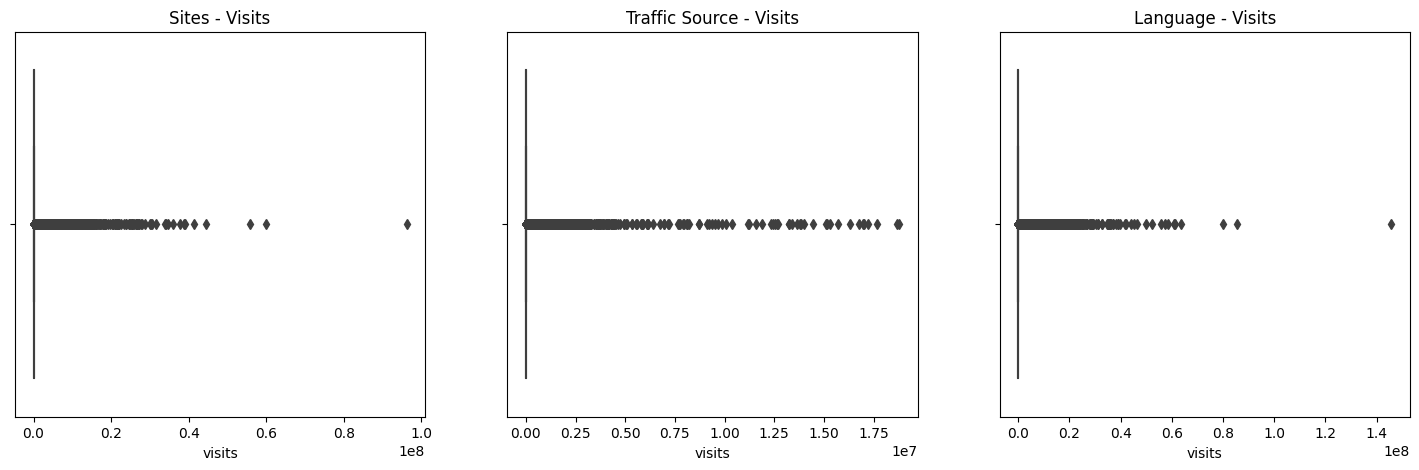

In [30]:

plt.figure(figsize=(18, 5))

# Create a boxplot for each report
plt.subplot(1, 3, 1)
sns.boxplot(data=df_sites, x='visits')
plt.title('Sites - Visits')

plt.subplot(1, 3, 2)
sns.boxplot(data=df_traffic_source, x='visits')
plt.title('Traffic Source - Visits')

plt.subplot(1, 3, 3)
sns.boxplot(data=df_language, x='visits')
plt.title('Language - Visits')

plt.show()

In [31]:
# Remove visit outliers with the interquartile range of the middle 50%.
sites_no_outliers = remove_outliers(df_sites['visits'])
traffic_source_no_outliers = remove_outliers(df_traffic_source['visits'])
language_no_outliers = remove_outliers(df_language['visits'])

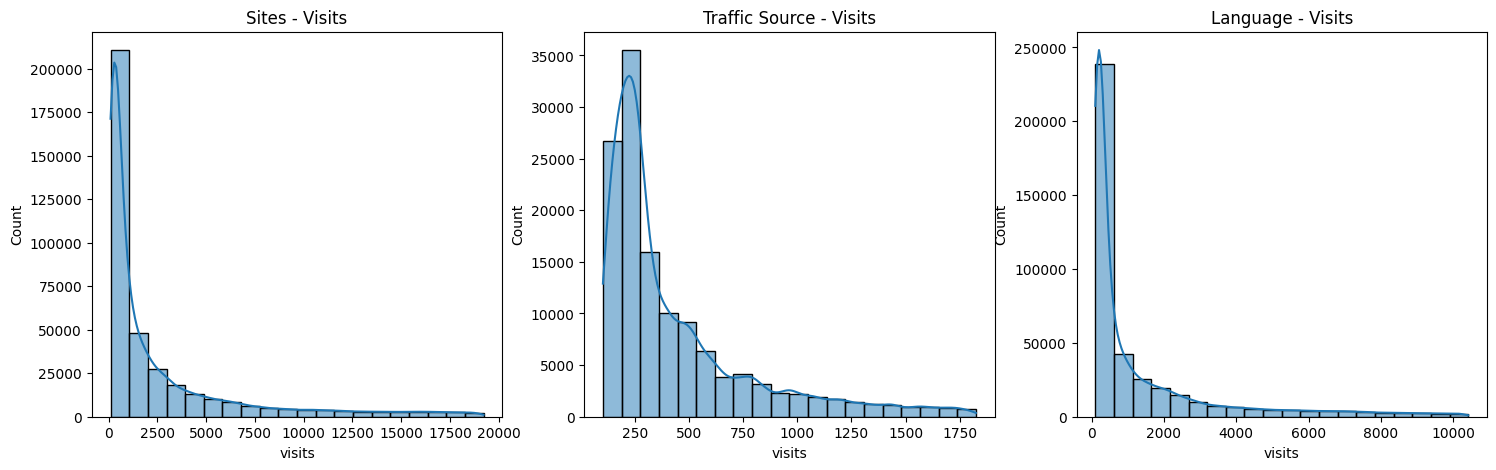

In [32]:
# Create a figure with a subplot for each agency.
plt.figure(figsize=(18, 5))

# Create a histogram for each report.
plt.subplot(1, 3, 1)
sns.histplot(data=sites_no_outliers, bins=20, kde=True)
plt.title('Sites - Visits')

plt.subplot(1, 3, 2)
sns.histplot(data=traffic_source_no_outliers, bins=20, kde=True)
plt.title('Traffic Source - Visits')

plt.subplot(1, 3, 3)
sns.histplot(data=language_no_outliers, bins=20, kde=True)
plt.title('Language - Visits')

# Show the plot
plt.show()

##### Question 6 Answer
To analyze the presence of outliers we looked at whether there are any domains with too high or too low # visits? After blox-potting the visits data for each of the three reports analyzed, we found this to be the case. We then decided to remove observations with visits outside of the interquartile range of the middle 50%. After removing outliers we created a histogram for each report and found the distribution to be smoother and within expectations, as it is typical for website traffic data to have a positive-skew distribution with a long right tail.

### Visualizing and Analyzing Results

1. What domains were the most visited (top 10) for each agency for the period of Q1’20 and Q2’20 (just when COVID started)
    - Any interesting observations?
    - No plot
2. For a given year (for instance, 2022 or 2020) can we spot any seasonal patterns in # visits across each of the main agencies
    - Graph: plot # daily visits per agency for a given year
    - Potentially zoom in a specific agency and plot 5 top domains
3. What are the most common sources of traffic to sites of each of the different agencies? What are the sources that grew the most y/y in 2022 (vs 2021)
    - Plot: cumulative visits per source (filter by top 5 sources) during 2022 for each agency
4. How many languages do sites from different agencies support? Are there any notable differences between language distribution across the 4 agencies selected? (for example: social-security might be x% ES language whereas 'postal-service' might be y%)
    - If possible, combine all english languages into one bucket, and same for other languages
    - 412 unique languages
    - Plot: stacked bar chart showing % distribution of top languages by agency

##### Question 1.
 What domains were the most visited (top 5) for the Postal Service and Treasury agencies during Q3'2020 (chose this period to investigate any potential impact from the COVID-19 pandemic in visits) and compared to Q2'2020. Any interesting observations?

In [33]:
df_sites_filtered = df_sites[(df_sites['report_agency'] == 'postal-service') | (df_sites['report_agency'] == 'treasury')]
df_q2q3 = df_sites_filtered[df_sites_filtered['date'].between('2020-04-01', '2020-09-30')]
df_top_domains = df_q2q3.groupby(['report_agency', 'domain', df_q2q3['date'].dt.quarter])['visits'].sum().reset_index()
top_domains = df_top_domains.pivot_table(index=['report_agency', 'domain'], columns='date', values='visits', fill_value=0).reset_index()
top_domains.columns = ['report_agency', 'domain', 'q2_visits', 'q3_visits']
top_domains['q3_visits_qoq_percent']=(top_domains['q3_visits'] / top_domains['q2_visits']-1)*100
top_domains = top_domains.sort_values(['report_agency', 'q3_visits'], ascending=[True, False])
for agency in top_domains['report_agency'].unique():
    print(f"Top 5 domains for {agency}:")
    print(top_domains[top_domains['report_agency'] == agency][['domain', 'q2_visits', 'q3_visits','q3_visits_qoq_percent']].head(5).to_string(index=False))
    print()

Top 5 domains for postal-service:
                   domain  q2_visits  q3_visits  q3_visits_qoq_percent
           tools.usps.com  953711937  835402203             -12.405185
             reg.usps.com  208508740  190619990              -8.579377
                 usps.com  164502863  147252828             -10.486161
informeddelivery.usps.com  135493630  122706681              -9.437306
               m.usps.com   50846333   35280494             -30.613494

Top 5 domains for treasury:
           domain  q2_visits  q3_visits  q3_visits_qoq_percent
          irs.gov  914964282  190860137             -79.140154
  sa.www4.irs.gov  522974424   78396639             -85.009470
     apps.irs.gov   13789871    7310393             -46.987227
home.treasury.gov   18181643    6654373             -63.400596
     treasury.gov    4433085    4269765              -3.684116



##### Question 1 Answer
- All sites across those two agencies saw meaninful traffic declines ranging from -5% to -80% quarter-over-quarter
- Particularly, all sites across the treasury agency saw large declines in quarter-over-quarter growth, which is aligned with expectations as tax season begins in Mar-Apr. 

##### Question 2
For a given year (for instance, 2021) can we spot any seasonal patterns in # visits across each of the main agencies.

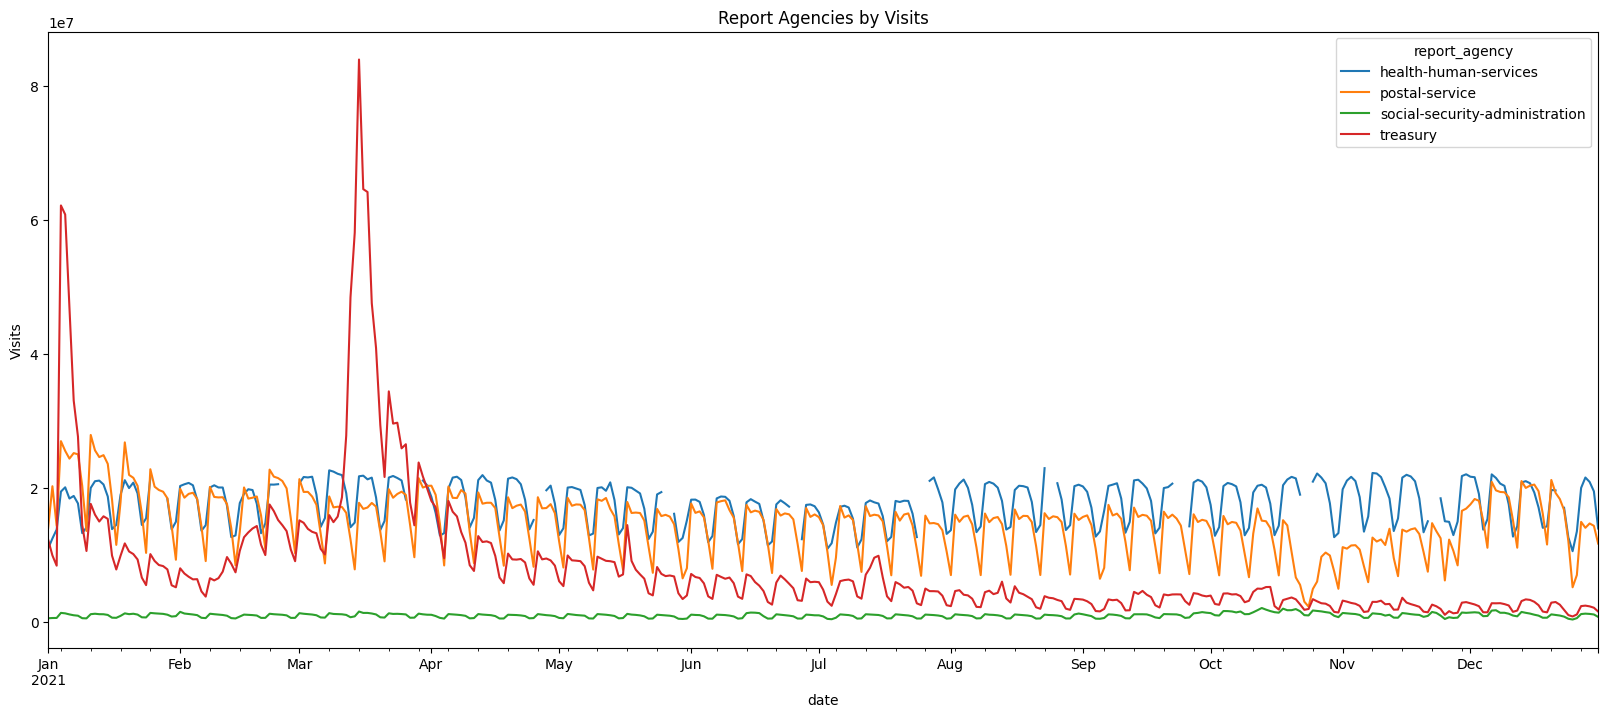

In [34]:
fig, ax = plt.subplots(figsize=(20, 8))

df_grouped = df_sites.groupby(['date', 'report_agency']).agg({'visits': 'sum'})
df_pivot = df_grouped.pivot_table(index='date', columns='report_agency', values='visits')

df_pivot = df_pivot.loc['2021-01': '2021-12']

df_pivot.plot.line(ax=ax)

plt.ylabel('Visits')
plt.title('Report Agencies by Visits')
plt.show()

##### Question 2 Answer
- Every agency's visits numbers have weekly seasonality patterns (weekdays have higher visits than weekends) and that is why we see a saw-toothed shape for all the plots.
- The clearest annual seasonal trend appears in Treasury domains, where tax season (March-April) sees a large spike of visits to then flatten out for the rest of the year.
- Postal service visits seem to have a seasonal pattern in Q4 where visits slowly ramp towards Black Friday and the holiday season.
- Social secutiry administration and health and human services have more stable patterns throughout the year with no notable seasonality.

##### Question 3
What are the most common sources of traffic to sites of each of the different agencies? What are the sources that grew the most y/y in 2022 (vs 2021)
- Plot: cumulative visits per source (filter by top 5 sources) during 2022 for each agency

In [35]:
# prints the top 5 most common sources of traffic for each agency
grouped_traffic = df_traffic_source.groupby(['report_agency', 'source']).agg({'visits': 'sum'})
sorted_traffic = grouped_traffic.sort_values(['report_agency', 'visits'], ascending=[True, False])
top_traffic_sources = sorted_traffic.groupby('report_agency').head(5)
print('Top 5 Most Common Sources of Traffic For Each Agency')
print()
print(top_traffic_sources)

Top 5 Most Common Sources of Traffic For Each Agency

                                                             visits
report_agency                  source                              
health-human-services          google                     494638104
                               (direct)                   100717595
                               pubmed.ncbi.nlm.nih.gov     27533997
                               bing                        17104640
                               ncbi.nlm.nih.gov            10471991
postal-service                 (direct)                   175586387
                               reg.usps.com               103254300
                               google                      90244097
                               usps.com                    74973767
                               informeddelivery.usps.com   38648380
social-security-administration google                     171627864
                               (direct)                    824

In [36]:
# print the top 10 highest percentage changes in visits for each traffic source
df_traffic_source_21_22 = df_traffic_source[df_traffic_source['date'].dt.year.isin([2021, 2022])]
grouped_traffic_21_22 = df_traffic_source_21_22.groupby(['source', df_traffic_source_21_22['date'].dt.year]).agg({'visits': 'sum'})
pct_change_traffic = grouped_traffic_21_22.unstack().pct_change(axis=1).stack()
sorted_pct_change_traffic = pct_change_traffic.rename(columns={'visits': 'Percentage Change in Visits'}).sort_values(by='Percentage Change in Visits', ascending=False)
print('Top 10 Highest Percentage Changes in Visits For Each Traffic Source From 2021 to 2022')
print()
print(sorted_pct_change_traffic.head(10))

Top 10 Highest Percentage Changes in Visits For Each Traffic Source From 2021 to 2022

                             Percentage Change in Visits
source                 date                             
secure.login.gov       2022                  4259.307975
api.id.me              2022                   104.368075
qa.pay.gov             2022                    85.107692
caweb.sba.gov          2022                    59.016515
thekrazycouponlady.com 2022                    55.965812
informeddelivery       2022                    51.246553
afdc.energy.gov        2022                    43.067720
pesquisa.bvsalud.org   2022                    36.358491
pnas.org               2022                    35.545946
browsinginfo.com       2022                    35.211618


##### Question 4 
How many languages do sites from different agencies support? Are there any notable differences between language distribution across the 4 agencies selected? (for example: social-security might be x% ES language whereas 'postal-service' might be y%)
- If possible, combine all english languages into one bucket, and same for other languages
- 412 unique languages
- Plot: stacked bar chart showing % distribution of top languages by agency

In [37]:
# reduce our languages subtypes to the main language supported and combine
import langcodes

df_language['language'] = df_language['language'].apply(lambda x: x.split('-')[0])
df_language.groupby('language')['visits'].sum().sort_values(ascending=False).head(50)

language
en           38262603021
es            2889688530
zh             889932940
fr             234448939
de             211227443
ja             196321952
pt             191797959
it             146112135
ko             129709991
ru             110142895
nl              87391156
tr              83505461
ar              68026418
vi              60076775
pl              49107907
sv              38792751
id              31172528
el              28860071
da              25968593
th              25548960
nb              22676596
he              18345134
ca              16394733
cs              15810403
fi              15171187
hu              14555696
ro              14060736
sk               9389538
hr               8295742
(not set)        8132958
fa               7511044
uk               6794352
c                6221171
sl               5367442
bg               4550113
sr               3995619
lt               3897723
hi               3694980
lv               1768550
et              

In [38]:
# see the unique languages
unique_languages = df_language['language'].unique()
print(unique_languages)

['en' 'es' 'zh' 'pt' 'fr' 'ko' 'it' 'de' 'ja' 'ru' 'nl' 'tr' 'ar' 'pl'
 'sv' 'da' 'el' 'id' 'nb' 'vi' 'th' 'he' 'fi' 'hu' 'cs' 'ro' 'ca'
 '(not set)' 'hr' 'sk' 'sl' 'bg' 'uk' 'fa' 'c' 'lt' 'sr' 'et' 'lv' 'hi'
 'fil' 'ms' 'is' 'mk' 'my' 'bs' 'ka' 'az' 'mr' 'eu' 'gl' 'ta' 'cy' 'sq'
 'bn' 'te' 'af' 'gu' 'am' 'pa' 'km' 'tl' 'ga' 'kn' 'kk' 'mn' 'no' 'us'
 'uz' 'qz' 'haw' 'jp' 'ml' 'en@us' 'zz' 'ur' 'lo' 'mi' 'to' 'bo' 'nn' 'ig'
 'iw' 'hy' 'sw' 'be' 'ckb' 'la' 'sm' 'yue' 'yo' 'q=0.8' 'q=0.9' 'lkt' 'co'
 'as' 'ht' 'so']


In [39]:
# identify the problem languages that are not recognized as valid language codes
recognized_languages = []
problem_languages = []

for lang in unique_languages:
    try:
        recognized_languages.append(langcodes.Language.get(lang).display_name())
    except:
        problem_languages.append(lang)

print(problem_languages)
print()
print(recognized_languages)
print()
print(len(recognized_languages))

['(not set)', 'c', 'en@us', 'q=0.8', 'q=0.9']

['English', 'Spanish', 'Chinese', 'Portuguese', 'French', 'Korean', 'Italian', 'German', 'Japanese', 'Russian', 'Dutch', 'Turkish', 'Arabic', 'Polish', 'Swedish', 'Danish', 'Greek', 'Indonesian', 'Norwegian Bokmål', 'Vietnamese', 'Thai', 'Hebrew', 'Finnish', 'Hungarian', 'Czech', 'Romanian', 'Catalan', 'Croatian', 'Slovak', 'Slovenian', 'Bulgarian', 'Ukrainian', 'Persian', 'Lithuanian', 'Serbian', 'Estonian', 'Latvian', 'Hindi', 'Filipino', 'Malay', 'Icelandic', 'Macedonian', 'Burmese', 'Bosnian', 'Georgian', 'Azerbaijani', 'Marathi', 'Basque', 'Galician', 'Tamil', 'Welsh', 'Albanian', 'Bangla', 'Telugu', 'Afrikaans', 'Gujarati', 'Amharic', 'Punjabi', 'Khmer', 'Filipino', 'Irish', 'Kannada', 'Kazakh', 'Mongolian', 'Norwegian', 'Unknown language [us]', 'Uzbek', 'Unknown language [qz]', 'Hawaiian', 'Unknown language [jp]', 'Malayalam', 'Unknown language [zz]', 'Urdu', 'Lao', 'Māori', 'Tongan', 'Tibetan', 'Norwegian Nynorsk', 'Igbo', 'Hebrew'

In [40]:
# set the valid language codes to their language word
langcodes.Language.get('en').display_name()

def get_language_name(lang_code):
    try:
        return langcodes.Language.get(lang_code).language_name()
    except:
        return lang_code

df_language['language'] = df_language['language'].apply(get_language_name)

In [41]:
print('Top 10 Languages by Visits Across All Agencies')
print()
df_language.groupby('language')['visits'].sum().sort_values(ascending=False).head(10)

Top 10 Languages by Visits Across All Agencies



language
English       38262603021
Spanish        2889688530
Chinese         889932940
French          234448939
German          211227443
Japanese        196321952
Portuguese      191797959
Italian         146112135
Korean          129709991
Russian         110142895
Name: visits, dtype: int64

In [42]:
df_agency_languages = df_language.groupby(['report_agency', 'language']).agg({'visits': 'sum'})
df_agency_languages = df_agency_languages.groupby(level=0).apply(lambda x: 100 * x / float(x.sum().item()))

for agency in df_agency_languages.index.levels[0]:
    print(f"Agency: {agency}")
    agency_langs = df_agency_languages.loc[agency].sort_values(by='visits', ascending=False)
    print(agency_langs)

Agency: health-human-services
                                                   visits
report_agency         language                           
health-human-services English                7.421869e+01
                      Spanish                1.285149e+01
                      Chinese                4.186847e+00
                      French                 1.037845e+00
                      German                 9.343562e-01
                      Japanese               9.149422e-01
                      Portuguese             8.842711e-01
                      Italian                7.012245e-01
                      Korean                 5.639237e-01
                      Russian                4.433723e-01
                      Dutch                  4.110191e-01
                      Turkish                3.767858e-01
                      Arabic                 3.324460e-01
                      Vietnamese             2.769134e-01
                      Polish              

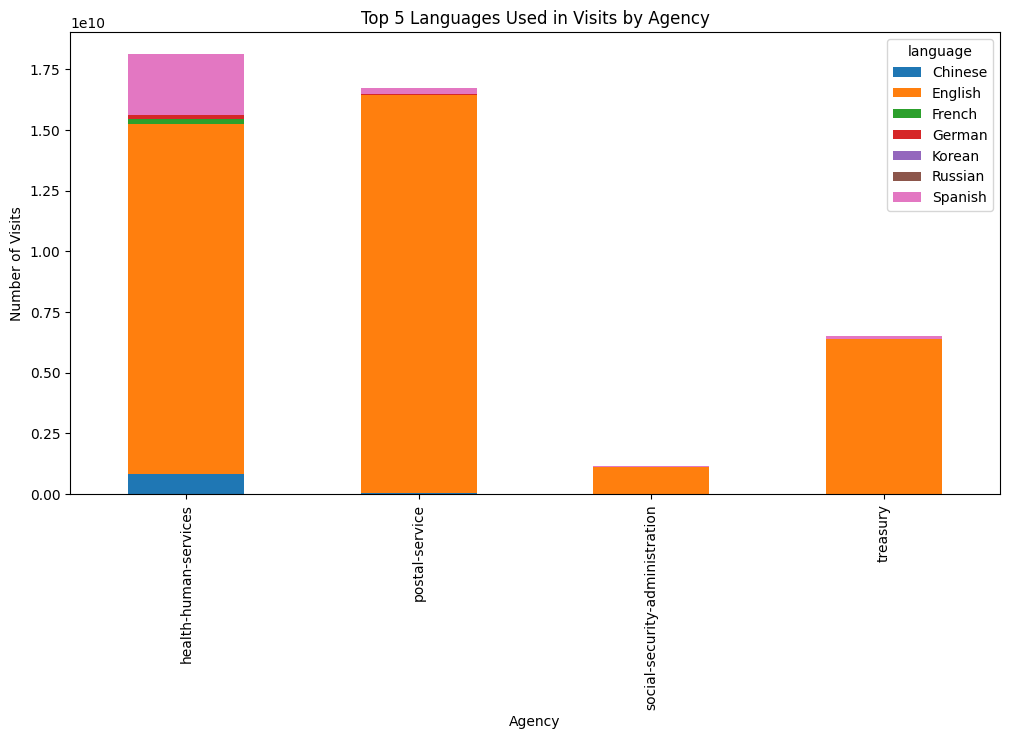

In [43]:
df_subset = df_language[['report_agency', 'language', 'visits']]

df_grouped = df_subset.groupby(['report_agency', 'language']).sum().reset_index()

top_5_languages = df_grouped.groupby('report_agency').apply(lambda x: x.nlargest(5, 'visits'))

pivot_table = top_5_languages.pivot(index='report_agency', columns='language', values='visits')

ax = pivot_table.plot(kind='bar', stacked=True, figsize=(12,6))

ax.set_xlabel('Agency')
ax.set_ylabel('Number of Visits')
ax.set_title('Top 5 Languages Used in Visits by Agency')

plt.show()

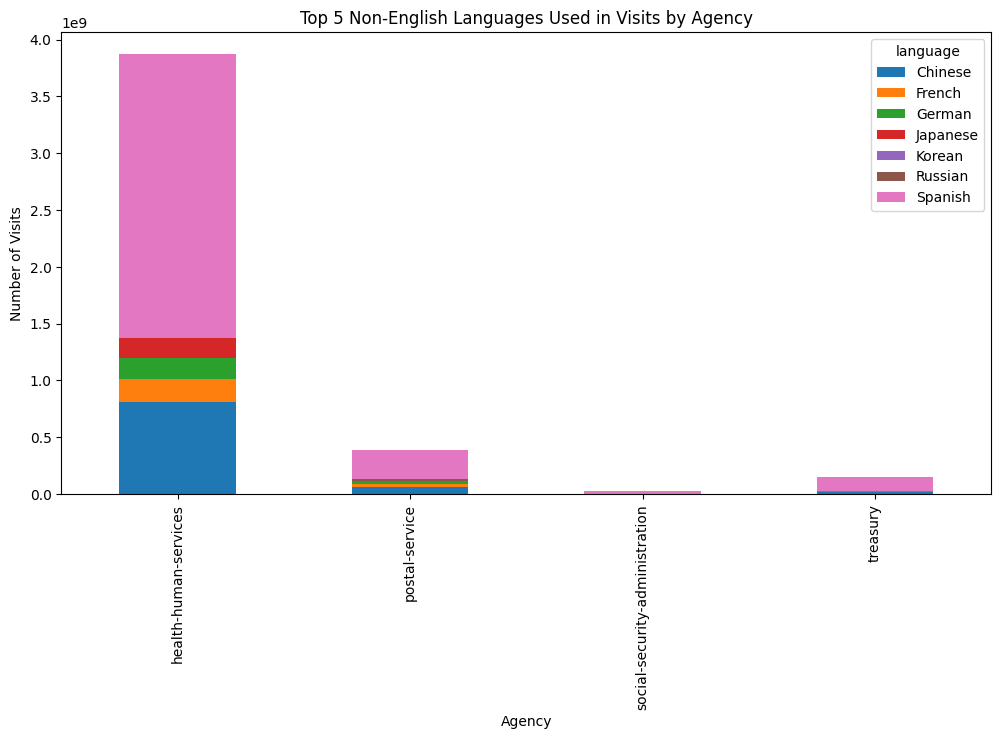

In [44]:
df_subset = df_language[['report_agency', 'language', 'visits']]

df_non_english = df_subset[df_subset['language'] != 'English']

df_grouped = df_non_english.groupby(['report_agency', 'language']).sum().reset_index()

top_5_languages = df_grouped.groupby('report_agency').apply(lambda x: x.nlargest(5, 'visits'))

pivot_table = top_5_languages.pivot(index='report_agency', columns='language', values='visits')

ax = pivot_table.plot(kind='bar', stacked=True, figsize=(12,6))

ax.set_xlabel('Agency')
ax.set_ylabel('Number of Visits')
ax.set_title('Top 5 Non-English Languages Used in Visits by Agency')

plt.show()